1. Setup

In [7]:
# --- 1. Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8")

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# Load engineered features
df = pd.read_parquet("../../data/processed/air_12318_features_full.parquet")

if 'time' in df.columns:
    df['time'] = pd.to_datetime(df['time'], errors='coerce')
else:
    raise KeyError("⚠️ 'time' is missing from features file. Check FeatureEngineering notebook.")
# Focus only on ON cycles
df_on = df[df['is_running'] == 1].copy()
print("Data shape (ON cycles):", df_on.shape)

# Select feature columns (drop ID/time-like fields)
feature_cols = [c for c in df_on.columns if c not in ['time','id','is_running']]
X = df_on[feature_cols].fillna(0).values


Data shape (ON cycles): (65154, 47)


In [8]:
# Ensure pf_anomaly exists
if 'pf_anomaly' not in df_on.columns:
    if 'pftot_None' in df_on.columns:
        df_on['pf_anomaly'] = np.abs(1 - df_on['pftot_None'])
    elif all(c in df_on.columns for c in ['ia_A','ib_A','ic_A','ptot_W']):
        total_current = df_on[['ia_A','ib_A','ic_A']].sum(axis=1).replace(0, np.nan)
        df_on['pf_est'] = df_on['ptot_W'] / (np.sqrt(3) * 400 * total_current)
        df_on['pf_anomaly'] = 1 - df_on['pf_est'].clip(0, 1).fillna(1)
    else:
        df_on['pf_anomaly'] = np.nan

# Ensure fuel_%_roc exists
if 'fuel_%_roc' not in df_on.columns and 'fuel_%' in df_on.columns:
    df_on['fuel_%_roc'] = df_on['fuel_%'].diff().fillna(0)


In [9]:
print("Columns:", df.columns.tolist()[:10])  # show first 10 col names
print("Has time:", 'time' in df.columns)
print("Time dtype:", df['time'].dtype)


Columns: ['time', 'id', 'epoch', 'air', 'device', 'mVa_V', 'mVb_V', 'mVc_v', 'mVa-mBb_V', 'mVb-mVc_V']
Has time: True
Time dtype: datetime64[ns, UTC]


Unsupervised Labels (Isolation Forest + One-Class SVM)

Isolation Forest

In [10]:
# --- 2. Isolation Forest ---
iso = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
df_on['anomaly_iforest'] = iso.fit_predict(X)

# Convert to 0=normal, 1=anomaly
df_on['anomaly_iforest'] = (df_on['anomaly_iforest'] == -1).astype(int)
print("IForest anomalies:", df_on['anomaly_iforest'].sum())


IForest anomalies: 652


One-Class SVM (⚠️ slow on big data, consider sampling)

In [11]:
# --- 3. One-Class SVM ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ocsvm = OneClassSVM(nu=0.01, kernel="rbf", gamma="scale")
df_on['anomaly_ocsvm'] = ocsvm.fit_predict(X_scaled)
df_on['anomaly_ocsvm'] = (df_on['anomaly_ocsvm'] == -1).astype(int)

print("OC-SVM anomalies:", df_on['anomaly_ocsvm'].sum())


OC-SVM anomalies: 652


Heuristic Labels

In [12]:
# --- Improved Heuristic Model (simple + safe) ---

df_h = df_on.copy()

# Rolling window (fixed number of samples to avoid errors)
ROLL_WINDOW = 20

# Compute rolling features safely
if 'temp_Degrees Celsius' in df_h.columns:
    df_h['temp_roll_mean'] = df_h['temp_Degrees Celsius'].rolling(ROLL_WINDOW, min_periods=1).mean()

if 'ptot_W' in df_h.columns:
    df_h['ptot_W_rollstd'] = df_h['ptot_W'].rolling(ROLL_WINDOW, min_periods=1).std()

if 'fuel_%' in df_h.columns:
    df_h['fuel_%_roc'] = df_h['fuel_%'].diff().fillna(0)

if all(c in df_h.columns for c in ['ia_A','ib_A','ic_A']):
    df_h['current_imbalance'] = df_h[['ia_A','ib_A','ic_A']].std(axis=1)

if all(c in df_h.columns for c in ['va_V','vb_V','vc_V']):
    df_h['voltage_imbalance'] = df_h[['va_V','vb_V','vc_V']].std(axis=1)

# Thresholds
def pct_thresh(series, pct):
    series = series.dropna()
    return series.quantile(pct) if len(series) > 0 else np.nan

th_temp = pct_thresh(df_h['temp_Degrees Celsius'], 0.995) if 'temp_Degrees Celsius' in df_h else np.nan
th_pf   = pct_thresh(df_h['pf_anomaly'], 0.99) if 'pf_anomaly' in df_h else np.nan
th_fuel = pct_thresh(df_h['fuel_%_roc'], 0.01) if 'fuel_%_roc' in df_h else np.nan
th_curr = pct_thresh(df_h['current_imbalance'], 0.99) if 'current_imbalance' in df_h else np.nan
th_volt = pct_thresh(df_h['voltage_imbalance'], 0.99) if 'voltage_imbalance' in df_h else np.nan

# Apply rules
scores = pd.DataFrame(index=df_h.index)
scores['temp'] = (df_h['temp_Degrees Celsius'] > th_temp).astype(int) if 'temp_Degrees Celsius' in df_h else 0
scores['pf']   = (df_h['pf_anomaly'] > th_pf).astype(int) if 'pf_anomaly' in df_h else 0
scores['fuel'] = (df_h['fuel_%_roc'] < th_fuel).astype(int) if 'fuel_%_roc' in df_h else 0
scores['curr'] = (df_h['current_imbalance'] > th_curr).astype(int) if 'current_imbalance' in df_h else 0
scores['volt'] = (df_h['voltage_imbalance'] > th_volt).astype(int) if 'voltage_imbalance' in df_h else 0

# Heuristic anomaly score
df_h['heuristic_score'] = scores.sum(axis=1) / max(1, scores.shape[1])

# Binary anomaly flag
df_h['anomaly_heuristic'] = (df_h['heuristic_score'] >= 0.4).astype(int)

# Update df_on
df_on['heuristic_score'] = df_h['heuristic_score']
df_on['anomaly_heuristic'] = df_h['anomaly_heuristic']

print("✅ Improved heuristic applied (fixed rolling window)")


✅ Improved heuristic applied (fixed rolling window)


In [13]:
methods = ['anomaly_iforest','anomaly_ocsvm','anomaly_heuristic']

def ensure_anomaly_votes(df):
    """
    Make sure anomaly_iforest, anomaly_ocsvm, anomaly_heuristic exist,
    and always create anomaly_votes.
    """
    # Add missing anomaly columns as zeros if they don't exist
    for m in methods:
        if m not in df.columns:
            print(f"⚠️ {m} not found, filling with 0s")
            df[m] = 0
    
    # Create anomaly_votes
    df['anomaly_votes'] = df[methods].sum(axis=1)
    return df

# Apply to both full dataset and ON-cycles dataset
df = ensure_anomaly_votes(df)
df_on = ensure_anomaly_votes(df_on)

print("✅ anomaly_votes ensured in both df and df_on")
print(df[['anomaly_iforest','anomaly_ocsvm','anomaly_heuristic','anomaly_votes']].head())


⚠️ anomaly_iforest not found, filling with 0s
⚠️ anomaly_ocsvm not found, filling with 0s
⚠️ anomaly_heuristic not found, filling with 0s
✅ anomaly_votes ensured in both df and df_on
   anomaly_iforest  anomaly_ocsvm  anomaly_heuristic  anomaly_votes
0                0              0                  0              0
1                0              0                  0              0
2                0              0                  0              0
3                0              0                  0              0
4                0              0                  0              0


In [14]:
# --- Sync anomaly columns back into full dataset (df) ---
for col in ['anomaly_iforest','anomaly_ocsvm','anomaly_heuristic']:
    if col in df_on.columns:
        # Fill only for ON rows; keep NaN for OFF rows
        df.loc[df_on.index, col] = df_on[col]

# Now ensure anomaly_votes exists in both
df = ensure_anomaly_votes(df)
df_on = ensure_anomaly_votes(df_on)

print("✅ Synced anomalies into both df and df_on")


✅ Synced anomalies into both df and df_on


Visualize Anomalies Over Time

In [15]:
print([c for c in df.columns if "anomaly" in c or "iforest" in c or "ocsvm" in c])


['anomaly_iforest', 'anomaly_ocsvm', 'anomaly_heuristic', 'anomaly_votes']


In [16]:
# --- 5. Compare agreement between methods ---
methods = ['anomaly_iforest','anomaly_ocsvm','anomaly_heuristic']
agreement = df_on[methods].mean()
print("Anomaly rates:\n", agreement)

# Create consensus anomaly vote count
df_on['anomaly_votes'] = df_on[methods].sum(axis=1)
print(df_on['anomaly_votes'].value_counts())


Anomaly rates:
 anomaly_iforest      0.010007
anomaly_ocsvm        0.010007
anomaly_heuristic    0.002671
dtype: float64
anomaly_votes
0    63943
1      986
2      183
3       42
Name: count, dtype: int64


In [17]:
# --- Combine anomaly detectors into a voting scheme ---

# Make sure all three anomaly columns exist
expected_cols = ['anomaly_iforest', 'anomaly_ocsvm', 'anomaly_heuristic']
missing = [col for col in expected_cols if col not in df_on.columns]
if missing:
    print("⚠️ Missing anomaly columns:", missing)
else:
    # Since all anomalies are already coded as 0=normal, 1=anomaly
    df_on['anomaly_votes'] = (
        df_on['anomaly_iforest'] +
        df_on['anomaly_ocsvm'] +
        df_on['anomaly_heuristic']
    )

    print("✅ Anomaly votes assigned.")
    print("\nVoting distribution:")
    print(df_on['anomaly_votes'].value_counts().sort_index())

    print("\nStrong anomalies (3 votes):", (df_on['anomaly_votes'] == 3).sum())
    print("Likely anomalies (2 votes):", (df_on['anomaly_votes'] == 2).sum())
    print("Weak anomalies (1 vote):", (df_on['anomaly_votes'] == 1).sum())


✅ Anomaly votes assigned.

Voting distribution:
anomaly_votes
0    63943
1      986
2      183
3       42
Name: count, dtype: int64

Strong anomalies (3 votes): 42
Likely anomalies (2 votes): 183
Weak anomalies (1 vote): 986


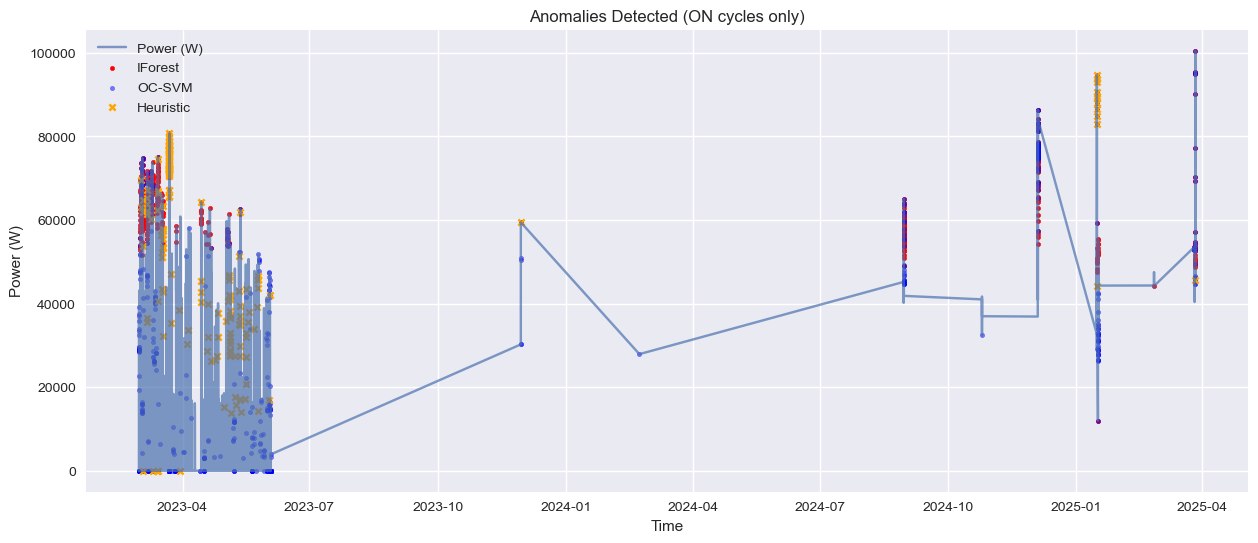

In [18]:
# --- 6. Visualize anomalies on top of power curve ---
plt.figure(figsize=(15,6))
plt.plot(df_on['time'], df_on['ptot_W'], label="Power (W)", alpha=0.7)

# Overlay anomalies
plt.scatter(df_on.loc[df_on['anomaly_iforest']==1,'time'],
            df_on.loc[df_on['anomaly_iforest']==1,'ptot_W'],
            color='red', s=10, label='IForest')

plt.scatter(df_on.loc[df_on['anomaly_ocsvm']==1,'time'],
            df_on.loc[df_on['anomaly_ocsvm']==1,'ptot_W'],
            color='blue', s=10, label='OC-SVM', alpha=0.5)

plt.scatter(df_on.loc[df_on['anomaly_heuristic']==1,'time'],
            df_on.loc[df_on['anomaly_heuristic']==1,'ptot_W'],
            color='orange', s=20, label='Heuristic', marker='x')

plt.legend()
plt.title("Anomalies Detected (ON cycles only)")
plt.xlabel("Time")
plt.ylabel("Power (W)")
plt.show()


In [19]:
# --- 7. Evaluation Proxy ---
# Since we don't have true failure logs, we can only measure overlap:
overlap_iforest_heur = (df_on['anomaly_iforest'] & df_on['anomaly_heuristic']).sum()
overlap_ocsvm_heur = (df_on['anomaly_ocsvm'] & df_on['anomaly_heuristic']).sum()

print("IForest ∩ Heuristic anomalies:", overlap_iforest_heur)
print("OCSVM ∩ Heuristic anomalies:", overlap_ocsvm_heur)


IForest ∩ Heuristic anomalies: 81
OCSVM ∩ Heuristic anomalies: 49


In [20]:
# Convert time to datetime index for grouping
df_on = df_on.set_index('time')

# Daily anomaly counts per method
daily_anomalies = df_on[['anomaly_iforest','anomaly_ocsvm','anomaly_heuristic']].resample('D').sum()

# Weekly anomaly counts per method
weekly_anomalies = df_on[['anomaly_iforest','anomaly_ocsvm','anomaly_heuristic']].resample('W').sum()

print("Daily anomalies (first 10 days):\n", daily_anomalies.head(10))
print("\nWeekly anomalies:\n", weekly_anomalies.head())


Daily anomalies (first 10 days):
                            anomaly_iforest  anomaly_ocsvm  anomaly_heuristic
time                                                                        
2023-02-28 00:00:00+00:00                0             31                  0
2023-03-01 00:00:00+00:00               20             10                  0
2023-03-02 00:00:00+00:00               75             28                  2
2023-03-03 00:00:00+00:00               44             22                  4
2023-03-04 00:00:00+00:00                0              4                  0
2023-03-05 00:00:00+00:00                0              0                  0
2023-03-06 00:00:00+00:00               53             19                  7
2023-03-07 00:00:00+00:00                0              7                  0
2023-03-08 00:00:00+00:00               37              0                  0
2023-03-09 00:00:00+00:00               46             21                  1

Weekly anomalies:
                       

<Figure size 1400x600 with 0 Axes>

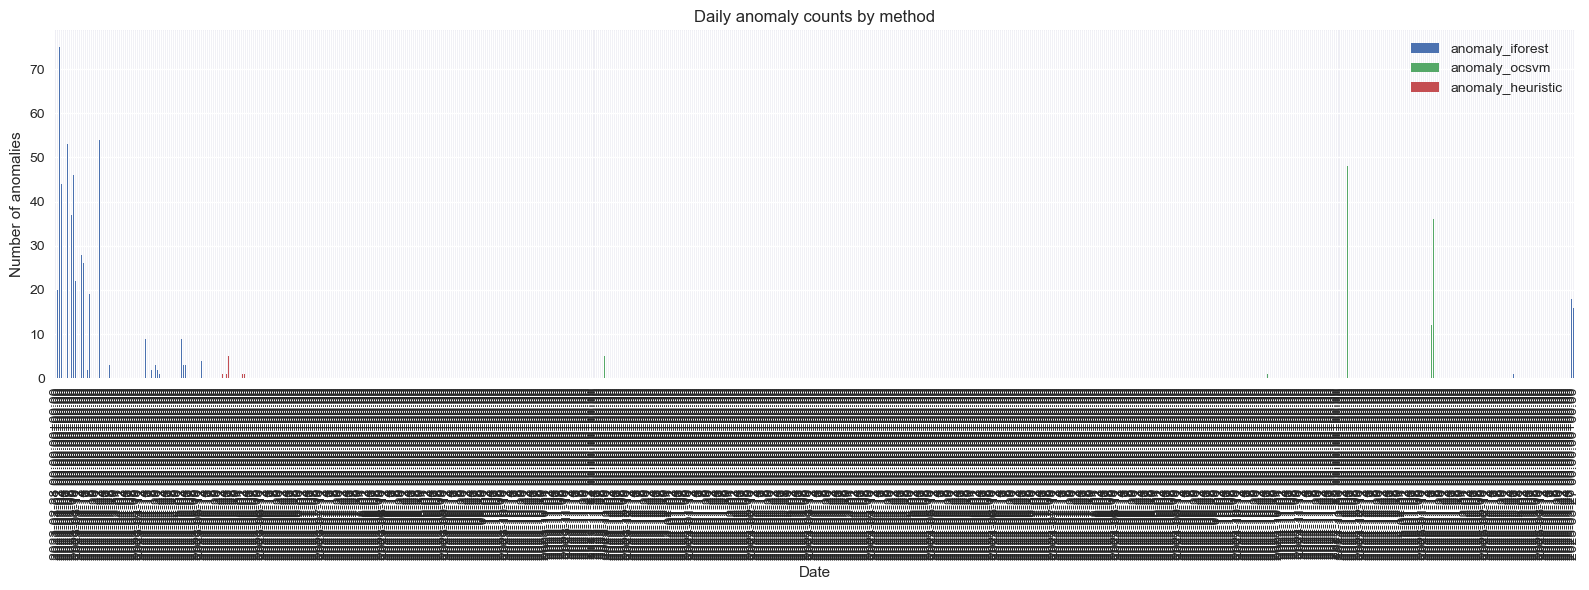

In [21]:
plt.figure(figsize=(14,6))
daily_anomalies.plot(kind='bar', stacked=False, figsize=(16,6))
plt.title("Daily anomaly counts by method")
plt.ylabel("Number of anomalies")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

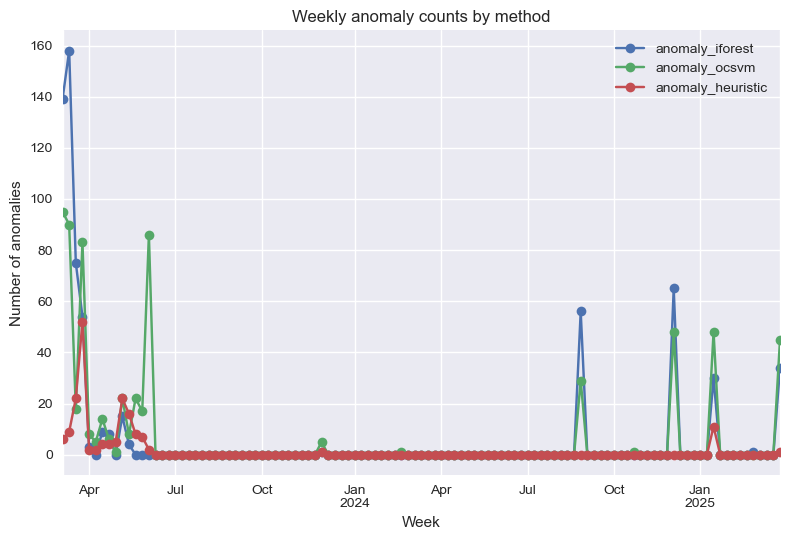

In [22]:
plt.figure(figsize=(12,6))
weekly_anomalies.plot(kind='line', marker='o')
plt.title("Weekly anomaly counts by method")
plt.ylabel("Number of anomalies")
plt.xlabel("Week")
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
print("df_on columns:", df_on.columns.tolist())
print("Number of rows:", len(df_on))
print("Anomaly votes value counts:")
print(df_on.get('anomaly_votes', pd.Series()).value_counts())


df_on columns: ['id', 'epoch', 'air', 'device', 'mVa_V', 'mVb_V', 'mVc_v', 'mVa-mBb_V', 'mVb-mVc_V', 'mVc-mVa_V', 'va_V', 'vb_V', 'vc_V', 'va-vb_V', 'vb-vc_V', 'vc-va_V', 'ia_A', 'ib_A', 'ic_A', 'pa_W', 'pb_W', 'pc_W', 'qa_Var', 'qb_Var', 'qc_Var', 'sa_VA', 'sb_VA', 'sc_VA', 'ptot_W', 'qtot_Var', 'stot_VA', 'pfa_None', 'pfb_None', 'pfc_None', 'pftot_None', 'expwh_Kwh*10', 'expvar_Kvarh*10', 'freq_Hz*10', 'temp_Degrees Celsius', 'pressure_Bar', 'fuel_%', 'vbat_V', 'hours_sec', 'is_running_gmm', 'any_current', 'is_running', 'pf_anomaly', 'fuel_%_roc', 'anomaly_iforest', 'anomaly_ocsvm', 'heuristic_score', 'anomaly_heuristic', 'anomaly_votes']
Number of rows: 65154
Anomaly votes value counts:
anomaly_votes
0    63943
1      986
2      183
3       42
Name: count, dtype: int64


In [24]:
print("df_on columns:", df_on.columns.tolist()[:20])
print("Index name:", df_on.index.name)
print(df_on.head(2))


df_on columns: ['id', 'epoch', 'air', 'device', 'mVa_V', 'mVb_V', 'mVc_v', 'mVa-mBb_V', 'mVb-mVc_V', 'mVc-mVa_V', 'va_V', 'vb_V', 'vc_V', 'va-vb_V', 'vb-vc_V', 'vc-va_V', 'ia_A', 'ib_A', 'ic_A', 'pa_W']
Index name: time
                                id       epoch    air  device  mVa_V  mVb_V  \
time                                                                          
2023-02-28 11:11:18+00:00  2271375  1677582678  12318       1    233  236.0   
2023-02-28 11:16:19+00:00  2271386  1677582979  12318       1    233  236.0   

                           mVc_v  mVa-mBb_V  mVb-mVc_V  mVc-mVa_V  ...  \
time                                                               ...   
2023-02-28 11:11:18+00:00  236.0      404.0      409.0      407.0  ...   
2023-02-28 11:16:19+00:00  236.0      404.0      410.0      407.0  ...   

                           is_running_gmm  any_current  is_running  \
time                                                                 
2023-02-28 11:11:18+00:00 

In [25]:
N = 5

# Ensure anomaly_votes exists
methods = ['anomaly_iforest','anomaly_ocsvm','anomaly_heuristic']
if 'anomaly_votes' not in df_on.columns:
    df_on['anomaly_votes'] = df_on[methods].sum(axis=1)

# Ensure time is a column
if df_on.index.name == 'time':
    df_on = df_on.reset_index()

# Pick top anomalies where all 3 methods agree
top_candidates = df_on[df_on['anomaly_votes'] == 3]

if len(top_candidates) == 0:
    print("⚠️ No anomalies found where all 3 methods agree.")
else:
    top_anoms = top_candidates.sample(min(N, len(top_candidates)), random_state=42)

    for t in top_anoms['time']:
        window = df_on.loc[
            (df_on['time'] >= t - pd.Timedelta("30m")) &
            (df_on['time'] <= t + pd.Timedelta("30m"))
        ]
        print(f"\n=== Anomaly window around {t} ===")
        print(window.head())



=== Anomaly window around 2023-03-22 13:37:56+00:00 ===
                           time       id       epoch    air  device  mVa_V  \
15344 2023-03-22 13:07:57+00:00  2348170  1679490477  12318       1      0   
15345 2023-03-22 13:09:57+00:00  2348184  1679490597  12318       1      0   
15346 2023-03-22 13:13:57+00:00  2348188  1679490837  12318       1      0   
15347 2023-03-22 13:15:56+00:00  2348196  1679490956  12318       1      0   
15348 2023-03-22 13:17:57+00:00  2348199  1679491077  12318       1      0   

       mVb_V  mVc_v  mVa-mBb_V  mVb-mVc_V  ...  is_running_gmm  any_current  \
15344    0.0    0.0        0.0        0.0  ...               1         True   
15345    0.0    0.0        0.0        0.0  ...               1         True   
15346    0.0    0.0        0.0        0.0  ...               1         True   
15347    0.0    0.0        0.0        0.0  ...               1         True   
15348    0.0    0.0        0.0        0.0  ...               1         True   


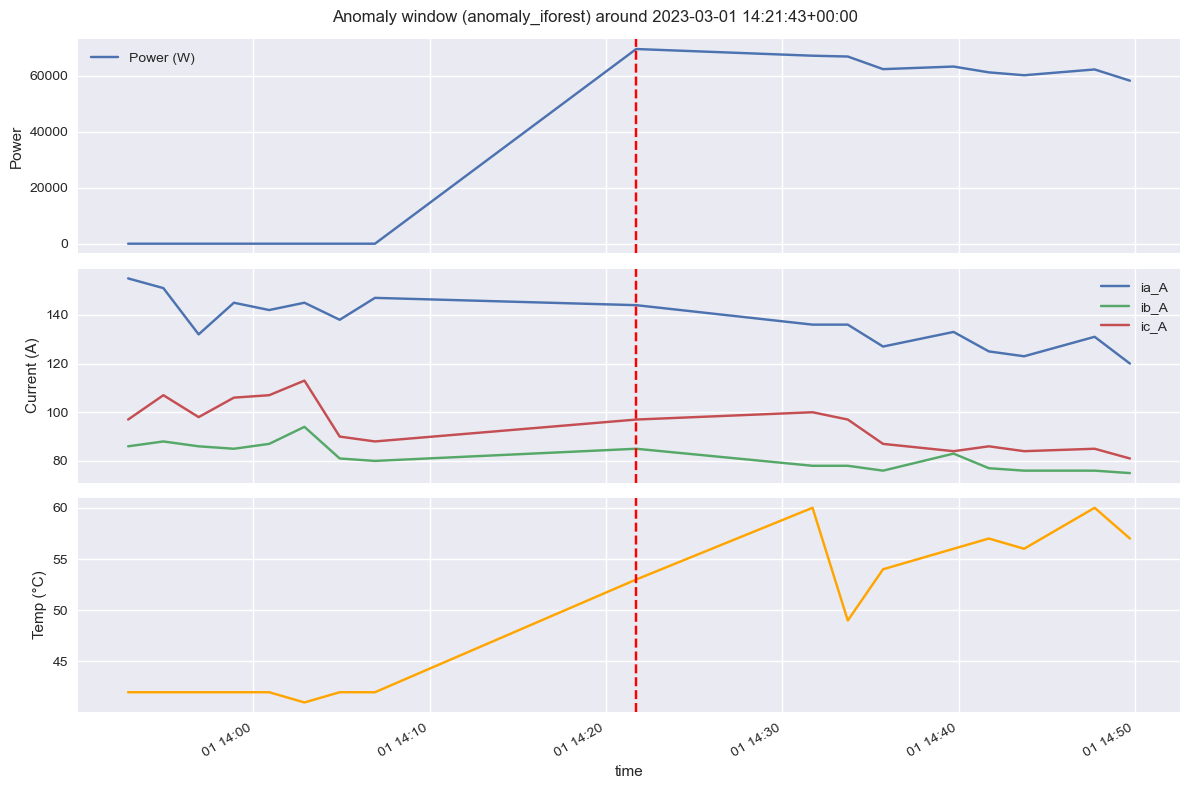

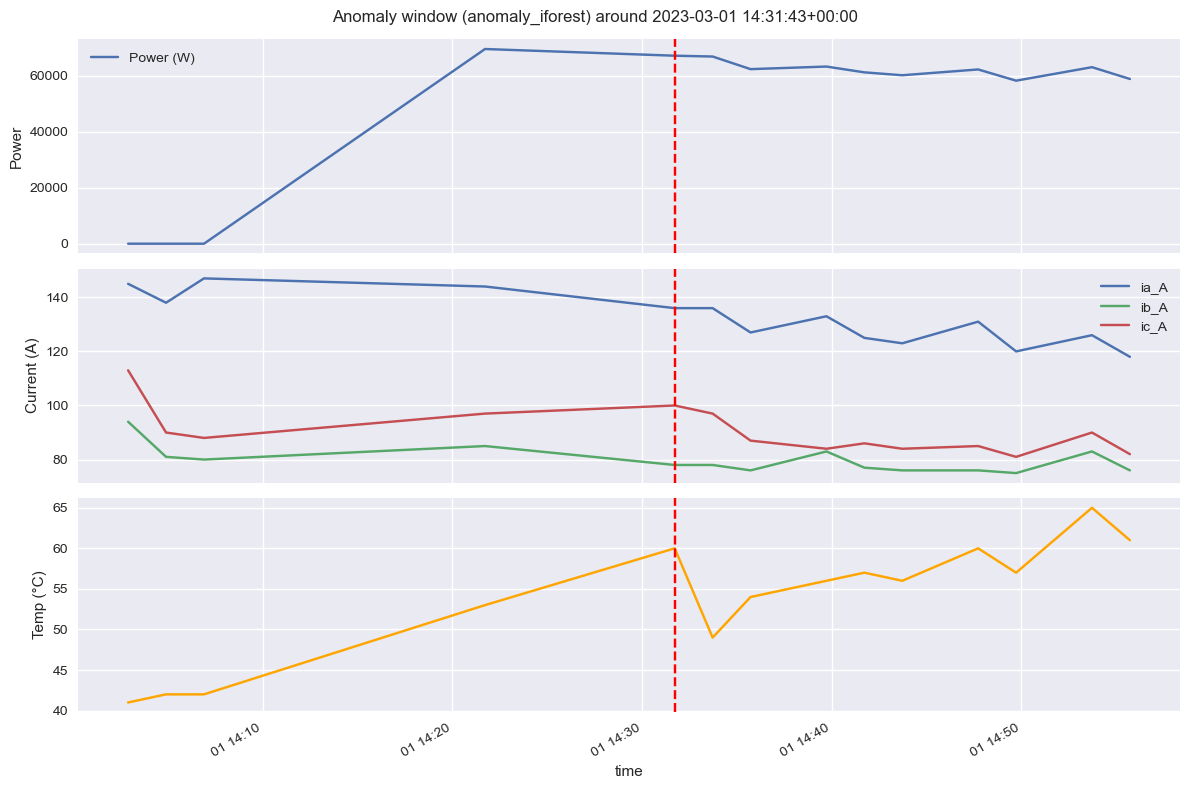

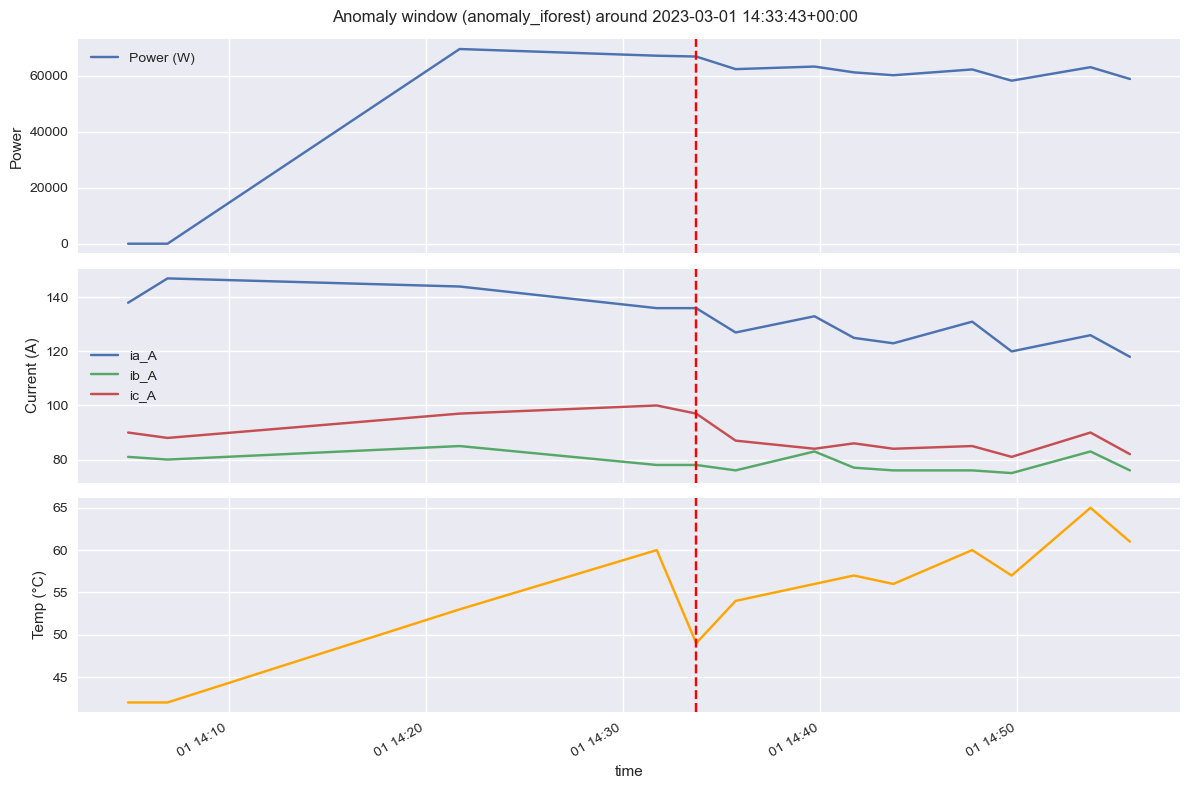

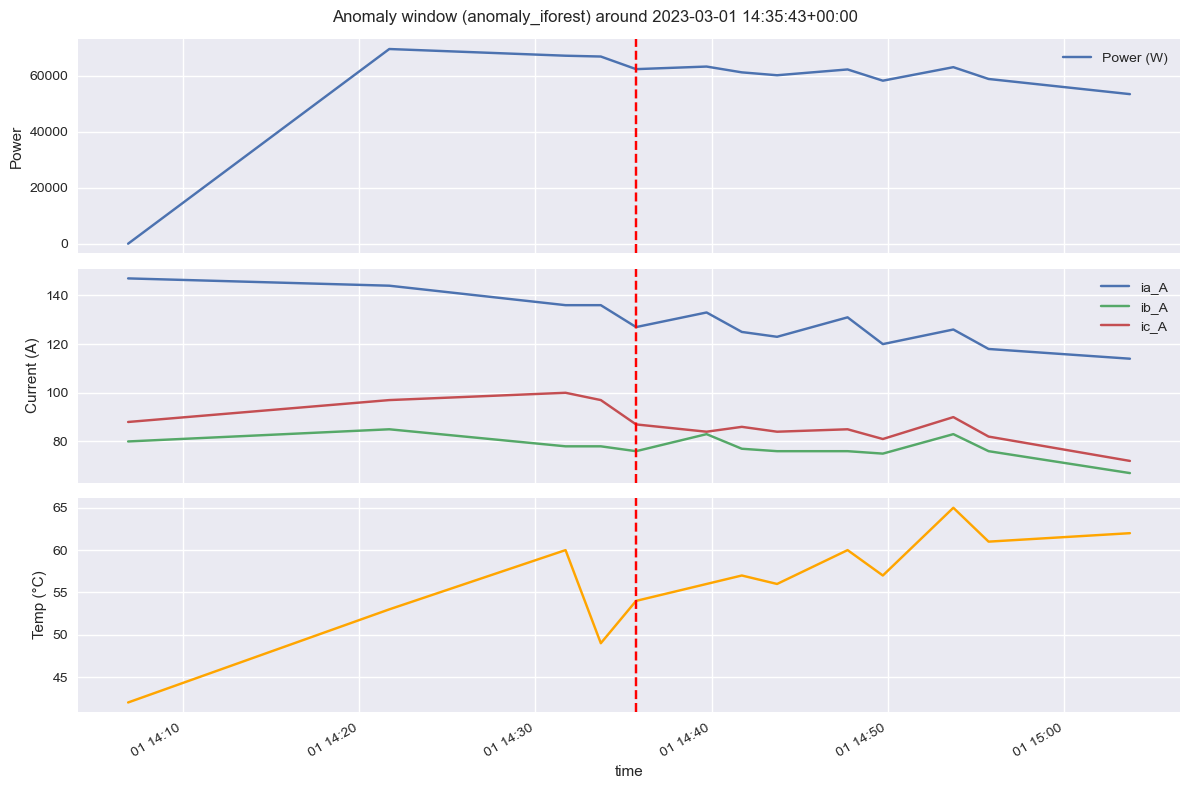

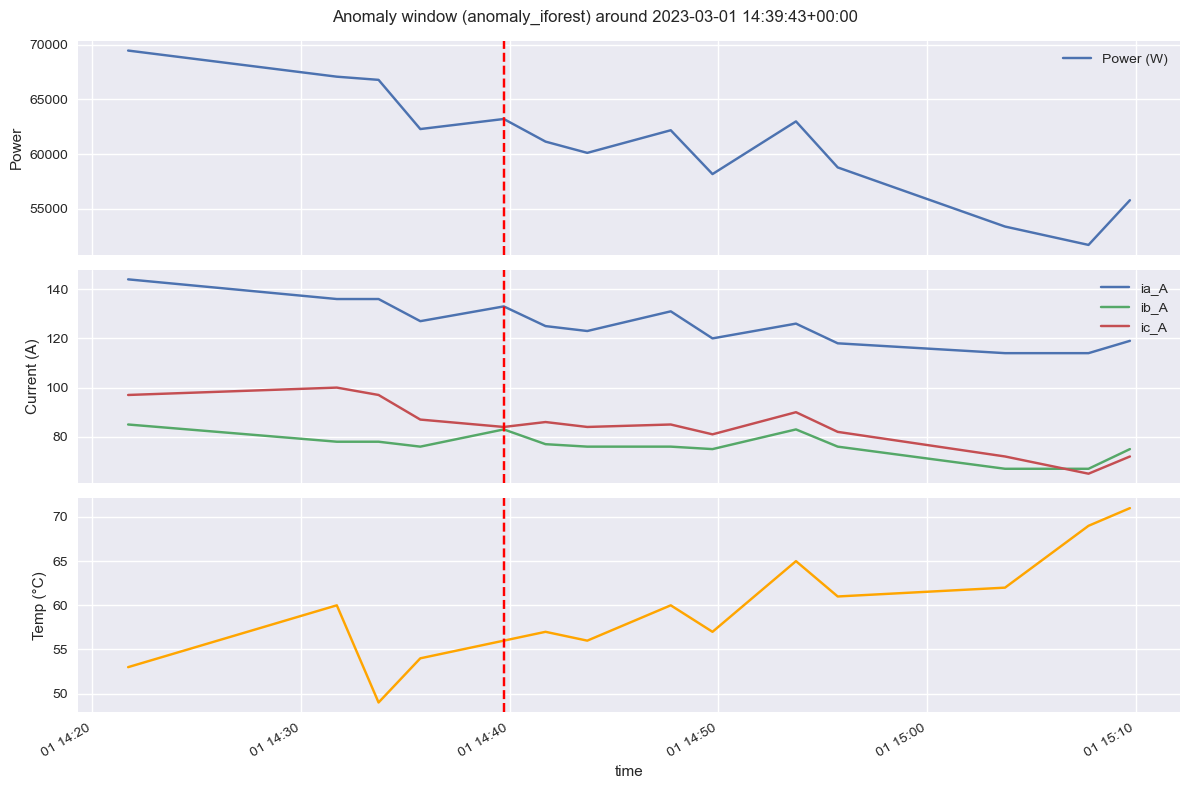

In [26]:
import matplotlib.dates as mdates

def plot_top_anomalies(df, method='anomaly_iforest', N=5, window='30min'):
    """
    Plot top N anomaly windows around detected anomalies.
    df: DataFrame with 'time' column or datetime index and anomaly columns
    method: which anomaly column to use ('anomaly_iforest', 'anomaly_ocsvm', etc.)
    N: number of anomalies to show
    window: time window around anomaly (e.g. '30min', '1h')
    """
    # Ensure time is index for easy slicing
    if 'time' in df.columns:
        df = df.set_index('time')
    df = df.sort_index()

    # Find anomaly timestamps
    anomaly_times = df.index[df[method] == 1]

    if len(anomaly_times) == 0:
        print(f"No anomalies found for {method}")
        return
    
    # Select first N anomalies
    selected_times = anomaly_times[:N]

    for t in selected_times:
        window_df = df.loc[t - pd.Timedelta(window): t + pd.Timedelta(window)]

        fig, axes = plt.subplots(3, 1, figsize=(12,8), sharex=True)

        if 'ptot_W' in window_df.columns:
            window_df['ptot_W'].plot(ax=axes[0], label="Power (W)")
            axes[0].axvline(t, color='red', linestyle='--')
            axes[0].set_ylabel("Power")
            axes[0].legend()

        if all(c in window_df.columns for c in ['ia_A','ib_A','ic_A']):
            window_df[['ia_A','ib_A','ic_A']].plot(ax=axes[1])
            axes[1].axvline(t, color='red', linestyle='--')
            axes[1].set_ylabel("Current (A)")

        if 'temp_Degrees Celsius' in window_df.columns:
            window_df['temp_Degrees Celsius'].plot(ax=axes[2], color='orange')
            axes[2].axvline(t, color='red', linestyle='--')
            axes[2].set_ylabel("Temp (°C)")

        plt.suptitle(f"Anomaly window ({method}) around {t}")
        plt.tight_layout()
        plt.show()

# Example usage
plot_top_anomalies(df_on, method='anomaly_iforest', N=5, window='30min')


In [27]:
print("Summary of Anomaly Detection")
print("- Total rows:", len(df))
print("- Strong anomalies (3 votes):", (df['anomaly_votes']==3).sum())
print("- Likely anomalies (2 votes):", (df['anomaly_votes']==2).sum())
print("- Weak anomalies (1 vote):", (df['anomaly_votes']==1).sum())


Summary of Anomaly Detection
- Total rows: 510797
- Strong anomalies (3 votes): 42
- Likely anomalies (2 votes): 183
- Weak anomalies (1 vote): 986


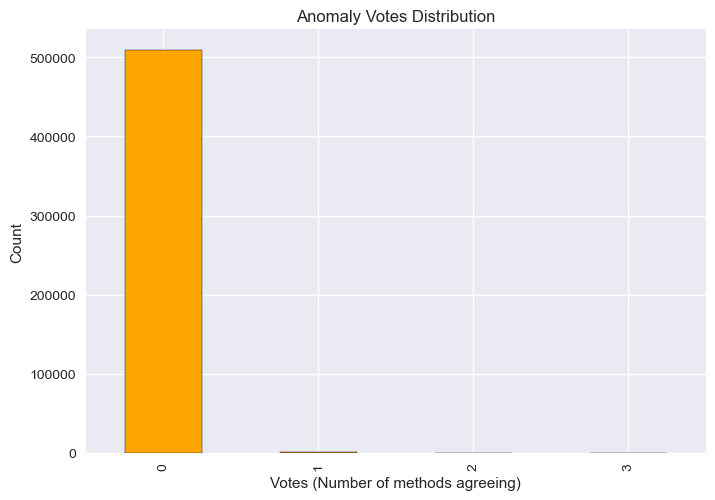

In [28]:
anomaly_summary = df['anomaly_votes'].value_counts().sort_index()

anomaly_summary.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Anomaly Votes Distribution")
plt.xlabel("Votes (Number of methods agreeing)")
plt.ylabel("Count")
plt.show()


In [29]:
import os

# Save dataset with anomaly columns
processed_dir = "../../data/processed"
out_path_parquet = os.path.join(processed_dir, "air_12318_with_anomalies.parquet")
out_path_csv = os.path.join(processed_dir, "air_12318_with_anomalies.csv")

# Make sure votes exist
methods = ['anomaly_iforest','anomaly_ocsvm','anomaly_heuristic']
if 'anomaly_votes' not in df.columns:
    df['anomaly_votes'] = df[methods].sum(axis=1)

df.to_parquet(out_path_parquet, index=True)
df.to_csv(out_path_csv, index=True)

print("✅ Saved dataset with anomalies:")
print("-", out_path_parquet)
print("-", out_path_csv)
print("Columns:", [c for c in df.columns if "anomaly" in c])


✅ Saved dataset with anomalies:
- ../../data/processed\air_12318_with_anomalies.parquet
- ../../data/processed\air_12318_with_anomalies.csv
Columns: ['anomaly_iforest', 'anomaly_ocsvm', 'anomaly_heuristic', 'anomaly_votes']
